# Installs & Imports

In [1]:
!python --version # requires 3.8+

Python 3.8.0


In [2]:
!pip install -q wget chess seaborn numpy pandas

In [3]:
!pip install pydot networkx graphviz

## Download the games

In [4]:
from utils import sanitize_url
from download import download
from pathlib import Path

In [5]:
#URL = 'https://lichess.org/games/export/seaghost27?max=100'
URL = 'https://lichess.org/games/export/DrNykterstein?max=500'
#URL = 'https://database.lichess.org/standard/lichess_db_standard_rated_2015-02.pgn.bz2'
URL = None
FILENAME = '../../chess365_d35.pgn'

if URL:    
    filename = sanitize_url(URL)
    pgn_filename = download(URL, filename)
    
else:
    pgn_filename = FILENAME
    
print(pgn_filename)

../../chess365_d35.pgn


## Build the trie

In [6]:
from game import games_generator_from_file, get_board_for_moves, build_move_df
from trie import make_game_trie, count_trie, filter_trie, get_sub_trie

In [7]:
MAX_GAMES = 200

games_gen = games_generator_from_file(pgn_filename, max_games=MAX_GAMES, sample=0.1, print_every=100)
trie = make_game_trie(games_gen)
print(count_trie(trie))

0
100
make_game_trie took 12.89s
200


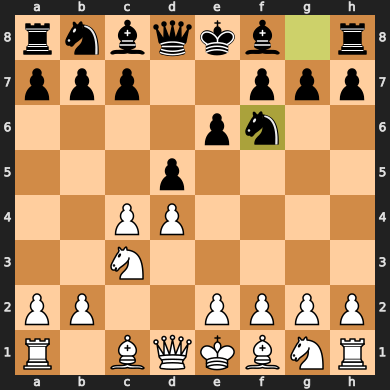

In [8]:
#LINE = ['e4', 'c5', 'Nf3', 'Nc6', 'd4', 'cxd4', 'Nxd4', ]  # open sicilian
LINE = ['d4', 'd5', 'c4', 'e6', 'Nc3', 'Nf6']  #
WHITE = None
BLACK = None

(BOARD := get_board_for_moves(LINE))

In [9]:
filtered_trie = filter_trie(trie,
                            moves=LINE,
                            white=WHITE,
                            black=BLACK)

line_trie = get_sub_trie(filtered_trie, LINE)
move_df = build_move_df(line_trie)
print(len(move_df))

134


## Statistics

In [10]:
from statistics import get_count_df
from utils import round_nearest

In [11]:
get_count_df(move_df,
             by='year',
             bin_width=1,
             map_fn=lambda df: round_nearest(df['year'] + (df['month']/12).round(1), 1))

move,Bf4,Bg5,Nf3,a3,cxd5,e3
year,,,,,,
2002,0.0,5.0,1.0,0.0,4.0,1.0
2003,1.0,26.0,10.0,1.0,9.0,0.0
2004,0.0,43.0,11.0,1.0,18.0,2.0


## Visualizing

In [12]:
from IPython.core.display import display, HTML
from cairosvg import svg2png
from report import generate_report

In [13]:
N = 5
ELO_BIN_WIDTH = 400
YEAR_BIN_WIDTH = 1

In [14]:
top_moves = move_df['move'].value_counts().iloc[:N].index.values.tolist()
print(top_moves)

top_moves_df = move_df[move_df['move'].isin(top_moves)]

['Bg5', 'cxd5', 'Nf3', 'e3', 'a3']


In [15]:
LINE

['d4', 'd5', 'c4', 'e6', 'Nc3', 'Nf6']

In [16]:
BOARD; svg2png(bytestring=BOARD._repr_svg_(), write_to='board.png')

### Moves by ELO and year

<Figure size 576x360 with 0 Axes>

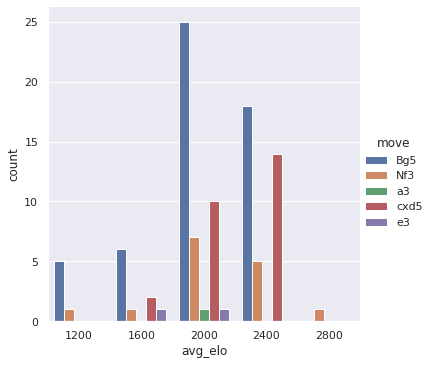

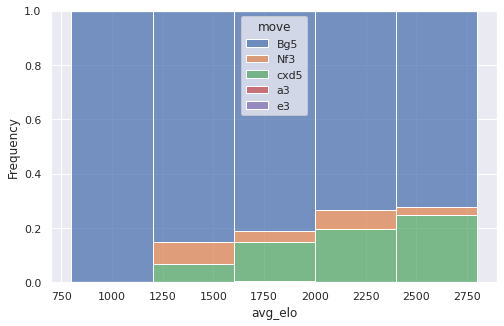

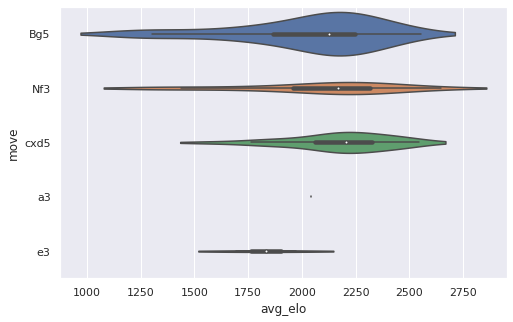

In [17]:
elo_report_html = generate_report(top_moves_df, var='avg_elo');
year_report_html = lambda x: x.split(' ')

move,Bg5,Nf3,a3,cxd5,e3
avg_elo,,,,,
1200,5.0,1.0,0.0,0.0,0.0
1600,6.0,1.0,0.0,2.0,1.0
2000,25.0,7.0,1.0,10.0,1.0
2400,18.0,5.0,0.0,14.0,0.0
2800,0.0,1.0,0.0,0.0,0.0
move,Bg5,Nf3,a3,cxd5,e3
avg_elo,,,,,
1200,0.833,0.167,0.000,0.000,0.000
1600,0.600,0.100,0.000,0.200,0.100

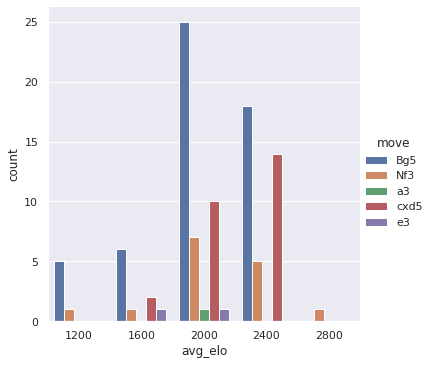
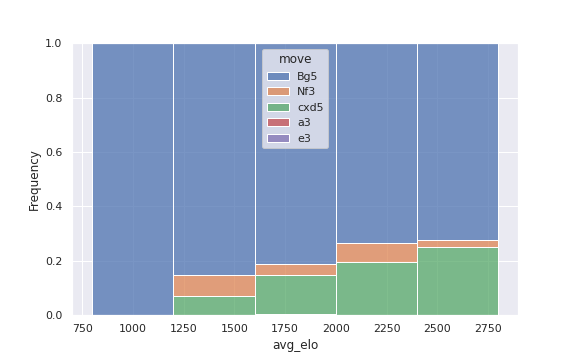
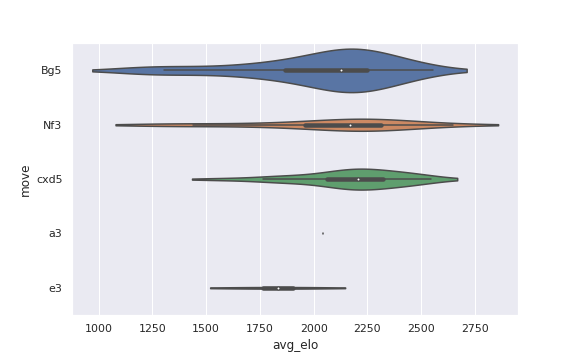

In [18]:
display(HTML(elo_report_html))

In [19]:
#display(HTML(year_report_html))

## Analysis

### Get most commons lines from starting position

In [20]:
from collections import namedtuple
import pandas as pd
import numpy as np
import networkx as nx
from analysis import get_top_lines

In [21]:
M = 20
D = 3

top_lines = get_top_lines(line_trie, max_depth=D)[:M]
top_lines_df = pd.DataFrame(line._asdict() for line in top_lines)

accum_prob = sum(l.score for l in top_lines)
print(f"{M} lines make up {accum_prob*100:.1f}% of the lines starting from {LINE}")
for line in top_lines:
    print(f"\t{np.round(line.score, 5)} {line.moves} {np.round(line.freqs, 3).tolist()} {line.counts}")

20 lines make up 76.1% of the lines starting from ['d4', 'd5', 'c4', 'e6', 'Nc3', 'Nf6']
	0.1194 ['Bg5', 'Be7', 'e3', 'O-O'] [0.552, 0.595, 0.705, 0.516] [74, 44, 31, 16]
	0.10448 ['cxd5', 'exd5', 'Bg5', 'Be7'] [0.231, 0.935, 0.966, 0.5] [31, 29, 28, 14]
	0.0597 ['cxd5', 'exd5', 'Bg5', 'Nbd7'] [0.231, 0.935, 0.966, 0.286] [31, 29, 28, 8]
	0.05224 ['Bg5', 'Nbd7', 'cxd5', 'exd5'] [0.552, 0.324, 0.292, 1.0] [74, 24, 7, 7]
	0.04478 ['Bg5', 'Be7', 'e3', 'h6'] [0.552, 0.595, 0.705, 0.194] [74, 44, 31, 6]
	0.04478 ['Bg5', 'Be7', 'cxd5', 'exd5'] [0.552, 0.595, 0.136, 1.0] [74, 44, 6, 6]
	0.04478 ['cxd5', 'exd5', 'Bg5', 'c6'] [0.231, 0.935, 0.966, 0.214] [31, 29, 28, 6]
	0.03731 ['Bg5', 'Nbd7', 'e3', 'c6'] [0.552, 0.324, 0.333, 0.625] [74, 24, 8, 5]
	0.03731 ['Bg5', 'Nbd7', 'Nf3', 'c6'] [0.552, 0.324, 0.375, 0.556] [74, 24, 9, 5]
	0.02985 ['Bg5', 'Be7', 'e3', 'Nbd7'] [0.552, 0.595, 0.705, 0.129] [74, 44, 31, 4]
	0.02239 ['Bg5', 'Be7', 'e3', 'c6'] [0.552, 0.595, 0.705, 0.097] [74, 44, 31, 3]
	0.

### AlphaZero Analysis

In [22]:
az_games_gen = games_generator_from_file('../../alphazero_220.pgn', print_every=100)
az_trie = make_game_trie(az_games_gen)
print(count_trie(az_trie))

0
100
200
make_game_trie took 65.93s
220


#### Find all games where a6 was played by white

In [23]:
count_trie(filter_trie(az_trie, white_moves={'a6'}))

32

### Garry Kasparov Analysis

In [24]:
from game import get_board_for_moves, get_boards_for_moves, get_FEN_to_games

def find_move_orders_reaching_fen(games, fen):
    move_orders = set()
    for game in games:
        for moves, board in get_boards_for_moves(game['moves']):
            if board.fen() == fen:
                move_orders.add(tuple(moves))
    return move_orders

In [25]:
qgd_fen = get_board_for_moves(['d4', 'd5', 'c4', 'e6',]).fen()
e4_e5_fen = get_board_for_moves(['e4', 'e5', ]).fen()
d4_Nf6_fen = get_board_for_moves(['d4', 'Nf6', ]).fen()

### Garry Kasparov Analysis

In [26]:
gk_games = list(games_generator_from_file('../../Garry_Kasparov.pgn', print_every=100, max_games=400))

error during pgn parsing
Traceback (most recent call last):
  File "/mnt/c/Users/Joe/Desktop/chess-analytics/venv/lib/python3.8/site-packages/chess/pgn.py", line 1651, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "/mnt/c/Users/Joe/Desktop/chess-analytics/venv/lib/python3.8/site-packages/chess/pgn.py", line 1032, in parse_san
    return board.parse_san(san)
  File "/mnt/c/Users/Joe/Desktop/chess-analytics/venv/lib/python3.8/site-packages/chess/__init__.py", line 2991, in parse_san
    raise ValueError(f"illegal san: {san!r} in {self.fen()}")
ValueError: illegal san: 'Bd3' in r1bqk1nr/pp3p1p/2np2pb/2p1p3/2B1P2P/2NP4/PPPN1PP1/R1BQK2R b KQkq - 1 9


0
100


error during pgn parsing
Traceback (most recent call last):
  File "/mnt/c/Users/Joe/Desktop/chess-analytics/venv/lib/python3.8/site-packages/chess/pgn.py", line 1651, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "/mnt/c/Users/Joe/Desktop/chess-analytics/venv/lib/python3.8/site-packages/chess/pgn.py", line 1032, in parse_san
    return board.parse_san(san)
  File "/mnt/c/Users/Joe/Desktop/chess-analytics/venv/lib/python3.8/site-packages/chess/__init__.py", line 2991, in parse_san
    raise ValueError(f"illegal san: {san!r} in {self.fen()}")
ValueError: illegal san: 'Nbd2' in r1bqk2r/1ppn1ppp/p1n1p3/2bpP3/5P2/2P2NP1/PP1P2BP/RNBQK2R w KQkq - 0 8
error during pgn parsing
Traceback (most recent call last):
  File "/mnt/c/Users/Joe/Desktop/chess-analytics/venv/lib/python3.8/site-packages/chess/pgn.py", line 1651, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "/mnt/c/Users/Joe/Desktop/chess-analytics/venv/lib/python3.8/site-packages/ches

200
300


In [27]:
#gk_FEN_to_games = get_FEN_to_games(gk_games)

In [28]:
#find_move_orders_reaching_fen(gk_games, qgd_fen)

In [29]:
gk_trie = make_game_trie(gk_games)
gk_top_lines = get_top_lines(gk_trie, max_depth=D)[:M]
gk_top_lines_df = pd.DataFrame(line._asdict() for line in gk_top_lines)

#accum_prob = sum(l.score for l in gk_top_lines)
#print(f"{M} lines make up {accum_prob*100:.1f}% of the lines starting from {[]}")
#for line in gk_top_lines:
#    print(f"\t{np.round(line.score, 5)} {line.moves} {np.round(line.freqs, 5).tolist()} {line.counts}")

make_game_trie took 0.02s


In [30]:
#top_positions = sorted([(len(gk_FEN_to_games[fen]), fen) for fen in gk_FEN_to_games], reverse=True)[:20]

### Accelerated Dragon Analysis

In [ ]:
from chess import Board
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from collections import namedtuple, defaultdict
plt.rcParams['axes.facecolor'] = 'white'

In [59]:
ad_games = list(games_generator_from_file('../../accel_drag_yugoslav.pgn'))
ad_trie = make_game_trie(ad_games)
ad_lines = get_top_lines(gk_trie, max_depth=50)

0
make_game_trie took 0.00s


In [61]:
ad_lines=ad_top_lines

In [ ]:
def graph_from_lines(lines):
    V, E = {}, []
    
    for depth, score, moves, freqs, counts in lines:
        prev_fen = None
        boards = [b for _, b in get_boards_for_moves(moves)]
        for i, (move, board) in enumerate(zip(moves, boards)):
            fen = board.fen()
            if fen not in V:
                V[fen] = len(V)
            if i > 0:
                E.append((V[prev_fen], V[fen]))
            prev_fen = fen
    return V, E
    

V, E = graph_from_lines(ad_lines)

G = nx.Graph()
for v in V:
    svg2png(bytestring=Board(v)._repr_svg_(), write_to='temp.png')
    G.add_node(V[v], image=mpimg.imread('temp.png'), size=1)
for e1, e2 in E:
    G.add_edge(e1, e2, weight=10)
weights = [G[u][v]['weight'] for u,v in E]
pos = graphviz_layout(G, prog='dot')
#labels = {idx:f"{l}" for l, idx in V.items()}
#color_map = ['white']*len(labels)

In [ ]:
ax=plt.gca()
fig=plt.gcf()
fig.set_size_inches(12, 12)
fig.set_dpi(50)
nx.draw_networkx(G, pos, ax=ax, width=weights)

#plt.xlim(-1.5,1.5)
#plt.ylim(-1.5,1.5)

trans=ax.transData.transform
trans2=fig.transFigure.inverted().transform

piesize=0.01 #this is the image size
p2=piesize/2.0
for n in G:
    xx,yy=trans(pos[n]) # figure coordinates
    xa,ya=trans2((xx,yy)) # axes coordinates
    a = plt.axes([xa-p2,ya-p2, piesize, piesize])
    a.imshow(G.nodes()[n]['image'])
    a.set_aspect('equal')
    a.axis('off')
ax.axis('off')
plt.show()